# Effective Hamiltonian

This notebook demonstrates how to calculate an effective Hamiltonian with the `pairinteraction.perturbative` module.
We use [PRX Quantum 6, 020332 (2025)](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.6.020332) as a reference and try to reproduce figure 2c) and d) from the paper.
Note that the paper used a Schrieffer-Wolff transformation to calculate the effective Hamiltonian, while here we use perturbation theory up to third order.

In [ ]:
%pip install -q matplotlib numpy pairinteraction

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction.real as pi
from pairinteraction import perturbative

In [2]:
if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

Let us define all single atom states of interest, as well as the fields and distances between the atoms used in the paper.

In [3]:
ket_atoms = {
    "+": pi.KetAtom("Rb", n=81, l=0, j=0.5, m=0.5),
    "0": pi.KetAtom("Rb", n=80, l=1, j=1.5, m=1.5),
    "-": pi.KetAtom("Rb", n=80, l=0, j=0.5, m=0.5),
}

magnetic_field = [0, 0, 60.7]  # in gauss

theta_list = np.linspace(0, 90, 20)  # degree
theta_default = 35.1  # degree

distance_list = np.linspace(8, 14, 20)  # mum
distance_default = 11.6  # mum

# $M_\mathrm{tot} = 0\,$ subspace
We start by considering the $M_\mathrm{tot} = 0\,$ two atom subspace, which contains the following states:
- |+, ->
- |0, 0>
- |-, +> 

And create the corresponding effective Hamiltonian for this subspace.

Note, that we can set the magnetic field as well as the interaction order of the effective Hamiltonian like we are used t from the `SystemAtom` class and the `SystemPair` class.

In [4]:
ket_tuples = [
    (ket_atoms["+"], ket_atoms["-"]),
    (ket_atoms["0"], ket_atoms["0"]),
    (ket_atoms["-"], ket_atoms["+"]),
]

eff_system = perturbative.EffectiveSystemPair(ket_tuples)
eff_system.set_perturbation_order(3)

# Set single atom properties
eff_system.set_magnetic_field([0, 0, 60.7], "gauss")
eff_system.set_diamagnetism_enabled(True)

# create a pair basis with at least 5000 ket pairs
eff_system.set_minimum_number_of_ket_pairs(5_000)

# set two atom properties
eff_system.set_interaction_order(3);

Now we can create the effective Hamiltonian for different distances and angles between the atoms.
Then from the effective Hamiltonians we can extract the parameters $V^\mathrm{offd}$, $V^\mathrm{diag}$, and $J^{00}$.

In [6]:
eff_h_dict = {"theta": [], "distance": []}
for theta in theta_list:
    eff_system.set_distance(distance_default, theta, "micrometer")
    eff_h_dict["theta"].append(eff_system.get_effective_hamiltonian(unit="MHz"))

for distance in distance_list:
    eff_system.set_distance(distance, theta_default, "micrometer")
    eff_h_dict["distance"].append(eff_system.get_effective_hamiltonian(unit="MHz"))

pair_energy_pm = eff_system.pair_energies[0].to("MHz", "spectroscopy").magnitude
J00 = {k: [eff_h[0, 1] for eff_h in eff_h_lists] for k, eff_h_lists in eff_h_dict.items()}
Voffd = {k: [eff_h[0, 2] for eff_h in eff_h_lists] for k, eff_h_lists in eff_h_dict.items()}
Vdiag = {
    k: [eff_h[0, 0] - pair_energy_pm for eff_h in eff_h_lists]
    for k, eff_h_lists in eff_h_dict.items()
}

Finally, we can plot the results for the different distances and angles to reproduce the $V^\mathrm{offd}$, $V^\mathrm{diag}$, and $J^{00}$ lines from the paper.

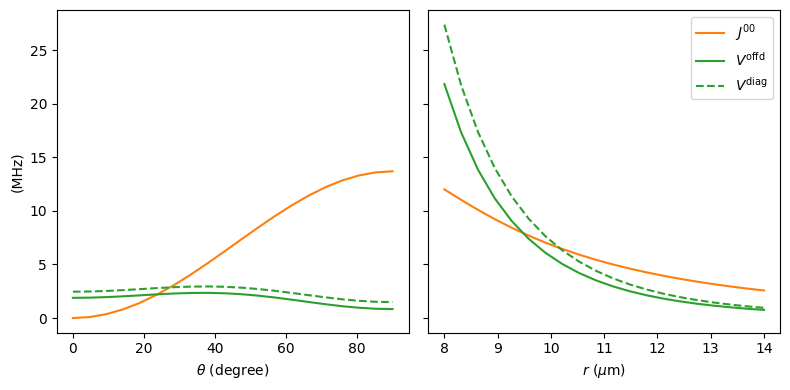

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

axs[0].plot(theta_list, J00["theta"], "C1-", label=r"$J^{00}$")
axs[0].plot(theta_list, Voffd["theta"], "C2-", label=r"$V^\text{offd}$")
axs[0].plot(theta_list, Vdiag["theta"], "C2--", label=r"$V^\text{diag}$")
axs[0].set_xlabel(r"$\theta$ (degree)")

axs[1].plot(distance_list, J00["distance"], "C1-", label=r"$J^{00}$")
axs[1].plot(distance_list, Voffd["distance"], "C2-", label=r"$V^\text{offd}$")
axs[1].plot(distance_list, Vdiag["distance"], "C2--", label=r"$V^\text{diag}$")
axs[1].set_xlabel(r"$r$ ($\mu$m)")

axs[0].set_ylabel(r"(MHz)")
axs[1].legend()

fig.tight_layout()
plt.show()

# $M_\mathrm{tot} = +1\,$ subspace
To also reproduce e.g. the $J^{+0}$ line from the paper, we can also consider the $M_\mathrm{tot} = +1\,$ two atom subspace, which contains the following states:
- |+, 0>
- |0, +>

And create the corresponding effective Hamiltonian for this subspace.

In [8]:
ket_tuples = [
    (ket_atoms["+"], ket_atoms["0"]),
    (ket_atoms["0"], ket_atoms["+"]),
]

eff_system = perturbative.EffectiveSystemPair(ket_tuples)
eff_system.set_perturbation_order(3)
eff_system.set_magnetic_field([0, 0, 60.7], "gauss")
eff_system.set_diamagnetism_enabled(True)
eff_system.set_minimum_number_of_ket_pairs(5_000)
eff_system.set_interaction_order(3)

eff_h_dict = {"theta": [], "distance": []}
for theta in theta_list:
    eff_system.set_distance(distance_default, theta, "micrometer")
    eff_h_dict["theta"].append(eff_system.get_effective_hamiltonian(unit="MHz"))

for distance in distance_list:
    eff_system.set_distance(distance, theta_default, "micrometer")
    eff_h_dict["distance"].append(eff_system.get_effective_hamiltonian(unit="MHz"))

Jp0 = {k: [eff_h[0, 1] for eff_h in eff_h_lists] for k, eff_h_lists in eff_h_dict.items()}

Plotting the results together with the previous results, we can reproduce the entire figure 2c) and d) from the paper.

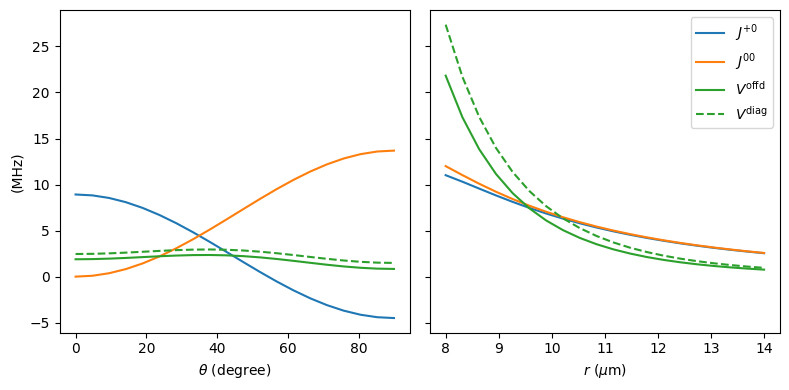

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

axs[0].plot(theta_list, Jp0["theta"], "C0-", label=r"$J^{+0}$")
axs[0].plot(theta_list, J00["theta"], "C1-", label=r"$J^{00}$")
axs[0].plot(theta_list, Voffd["theta"], "C2-", label=r"$V^\text{offd}$")
axs[0].plot(theta_list, Vdiag["theta"], "C2--", label=r"$V^\text{diag}$")
axs[0].set_xlabel(r"$\theta$ (degree)")

axs[1].plot(distance_list, Jp0["distance"], "C0-", label=r"$J^{+0}$")
axs[1].plot(distance_list, J00["distance"], "C1-", label=r"$J^{00}$")
axs[1].plot(distance_list, Voffd["distance"], "C2-", label=r"$V^\text{offd}$")
axs[1].plot(distance_list, Vdiag["distance"], "C2--", label=r"$V^\text{diag}$")
axs[1].set_xlabel(r"$r$ ($\mu$m)")

axs[0].set_ylabel(r"(MHz)")
axs[1].legend()

fig.tight_layout()
plt.show()